In [0]:
## バージョンを指定する場合、セルをコメントアウトしてください。
#!pip install torch==0.4.1
#!pip install torchvision==0.2.1
#!pip install numpy==1.14.6
#!pip install matplotlib==2.1.2
#!pip install Pillow==5.0.0

In [0]:
# version
import torch
print(torch.__version__)

1.1.0


In [0]:
# GPU
import torch
torch.cuda.is_available()

True

# Google Driveへのマウント（Colab利用時のみ）
mount Google Drive

In [0]:
# Google Driveにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls

gdrive	sample_data


In [0]:
# Data open
!cp gdrive/My\ Drive/original/FujiFilm/input-8307b45d-57f6-4190-a141-50d5bf233507.zip .
!unzip -q input-8307b45d-57f6-4190-a141-50d5bf233507.zip

In [0]:
# File
!ls

gdrive	input  input-8307b45d-57f6-4190-a141-50d5bf233507.zip  sample_data


In [0]:
import os
import sys
"""
# 自分用
sys.path.append('/content/gdrive/My Drive/github/pytorch_handbook/chapter7')
"""

# make git clone
!git clone https://github.com/HsgW-bB/pytorch_handbook
sys.path.append('/content/pytorch_handbook/chapter7')

In [0]:
sys.path

['',
 '/env/python',
 '/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '/usr/local/lib/python3.6/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.6/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/github/pytorch_handbook/chapter7']

In [0]:
# フォルダweights未作成の場合に作成
# make weight file
if not os.path.exists('weights/'):
    os.mkdir('weights/')

# SSDネットワークの学習
DeepLearning using SSD

In [0]:
character_list = [str(i) for i in range(10)]
character_list

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [0]:
from data import *
from utils.augmentations import *
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.utils.data as data
import argparse
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from layers import *
from layers.box_utils import match, log_sum_exp
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import torchvision.transforms as transforms
from difflib import SequenceMatcher
from numpy import random
import json
from pathlib import Path
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
from utils.augmentations import SSDAugmentation
from layers.modules import MultiBoxLoss
from ssd import build_ssd
import os
import sys
import argparse

sns.set()

In [0]:
# 学習の再開時はargs['resume']にパラメータファイルを指定
args = {'dataset':'VOC',
        'basenet':'vgg16_reducedfc.pth',
        'batch_size':12,
        'resume':'',
        'start_iter':0,
        'num_workers':4,
        'cuda':True,
        'lr':5e-4,
        'momentum':0.9,
        'weight_decay':5e-4,
        'gamma':0.1,
        'save_folder':'weights/'
       }

In [0]:
# Tensor作成時のデフォルトにGPU Tensorを設定
if torch.cuda.is_available():
    if args['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not args['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

In [0]:
# 訓練データの設定
# Config training data
cfg = voc
dataset = VOCDetection(root='input', image_sets='train',
                       transform=SSDAugmentation(cfg['min_dim'],
                                                 MEANS))

In [0]:
cfg

{'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
 'clip': True,
 'feature_maps': [38, 19, 10, 5, 3, 1],
 'lr_steps': (800, 1000, 1200),
 'max_iter': 1200,
 'max_sizes': [60, 111, 162, 213, 264, 315],
 'min_dim': 300,
 'min_sizes': [30, 60, 111, 162, 213, 264],
 'name': 'VOC',
 'num_classes': 11,
 'steps': [8, 16, 32, 64, 100, 300],
 'variance': [0.1, 0.2]}

In [0]:
sample0 = dataset[0]
print(sample0[0])
print(sample0[0].size(), '\n')
print(sample0[1])
print(sample0[1].shape)

tensor([[[107.0000, 108.6300, 109.6917,  ...,  -3.5334,   1.4450,  -1.0000],
         [107.8400, 109.0136, 110.1653,  ...,  -4.5904,  -1.1478,  -2.6800],
         [109.4000, 109.7260, 111.0450,  ...,  -6.5534,  -5.9630,  -5.8000],
         ...,
         [  2.2000,   3.1780,   6.0283,  ...,  81.2933,  82.5850,  83.4000],
         [  2.7200,   4.1218,   6.7087,  ...,  78.6543,  81.0250,  81.8400],
         [  3.0000,   4.6300,   7.0750,  ...,  77.2333,  80.1850,  81.0000]],

        [[121.0000, 122.6300, 123.6917,  ...,  42.0832,  48.8150,  48.0000],
         [121.8400, 122.7854, 124.0790,  ...,  41.0262,  46.2222,  46.3200],
         [123.4000, 123.0740, 124.7983,  ...,  39.0633,  41.4070,  43.2000],
         ...,
         [ 46.2000,  47.1780,  50.5817,  ...,  92.9866,  95.3850,  96.2000],
         [ 46.7200,  48.1218,  50.9023,  ...,  90.5469,  93.3050,  94.1200],
         [ 47.0000,  48.6300,  51.0750,  ...,  89.2333,  92.1850,  93.0000]],

        [[137.0000, 138.6300, 139.6917,  ...

In [0]:
# make figure
_range = np.linspace(0, 1, len(character_list))
cmap = plt.get_cmap('gist_rainbow')
color_map_list = [cmap(i) for i in _range]

def show_bboxes(data):
    img = data[0]
    img = torch.transpose(img, 2, 0)
    img = torch.transpose(img, 0, 1)
    img = img.numpy()

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    #Resize annotation to image size
    data[1][:, :4] *= 300
    print(data[1])

    for bbox in data[1]:
        xmin = bbox[0]
        ymin = bbox[1]
        xmax = bbox[2]
        ymax = bbox[3]
        label = bbox[4]
        label = int(label)
        label = '{}'.format(label)
        
        if label in character_list:
            plt.gca().add_patch(
                patches.Rectangle(
                    xy=(xmin, ymin), width=(xmax - xmin), height=(ymax - ymin),
                    fill=False,
                    edgecolor=color_map_list[character_list.index(label)]))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[147.87535411 149.21465969 164.02266289 201.04712042   9.        ]
 [173.37110482 147.64397906 190.36827195 204.18848168   3.        ]
 [231.16147309 146.07329843 249.00849858 204.18848168   7.        ]
 [264.30594901 149.21465969 285.55240793 208.90052356   2.        ]]


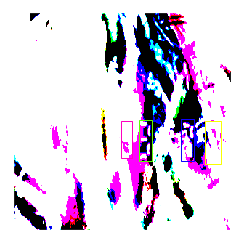

In [0]:
show_bboxes(sample0)

In [0]:
# ネットワークの定義
# Define Network
ssd_net = build_ssd('train', cfg['min_dim'], cfg['num_classes'])
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# ネットワークをGPUに転送
# Network to GPU
net = ssd_net.to(device)

In [0]:
# ネットワークのモジュールリストを出力
print(net)

SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(256, 

In [0]:
if args['cuda']:
    net = torch.nn.DataParallel(ssd_net)
    cudnn.benchmark = True

In [0]:
def adjust_learning_rate(optimizer, gamma, step):
    """Sets the learning rate to the initial LR decayed by 10 at every
        specified step
    # Adapted from PyTorch Imagenet example:
    # https://github.com/pytorch/examples/blob/master/imagenet/main.py
    """
    lr = args['lr'] * (gamma ** (step))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def xavier(param):
    init.xavier_uniform_(param)


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        xavier(m.weight.data)
        m.bias.data.zero_()

In [0]:
# 新規モデル学習時は追加ネットワークの畳み込み、位置推定、クラス分類の畳み込みパラメータを初期化する
# Initializing parameter
if not args['resume']:
    print('Initializing weights...')
    # initialize newly added layers' weights with xavier method
    ssd_net.extras.apply(weights_init)
    ssd_net.loc.apply(weights_init)
    ssd_net.conf.apply(weights_init)

Initializing weights...


In [0]:
# 損失関数の設定
# Config loss function
criterion = MultiBoxLoss(cfg['num_classes'], 0.5, True, 0, True, 3, 0.5,
                         False, args['cuda'])

In [0]:
# 最適化パラメータの設定
# Config optimize parameter
optimizer = optim.SGD(net.parameters(), lr=args['lr'], momentum=args['momentum'],
                      weight_decay=args['weight_decay'])

In [0]:
# 訓練モード
net.train()
# loss counters
loc_loss = 0
conf_loss = 0
epoch = 0
print('Loading the dataset...')

epoch_size = len(dataset) // args['batch_size']
print('dataset_size', len(dataset))
print('epoch_size', epoch_size)
print('Training SSD on:', dataset.name)
print('Using the specified args:')
print(args)

step_index = 0

Loading the dataset...
dataset_size 6162
epoch_size 513
Training SSD on: Fuji
Using the specified args:
{'dataset': 'VOC', 'basenet': 'vgg16_reducedfc.pth', 'batch_size': 12, 'resume': '', 'start_iter': 0, 'num_workers': 4, 'cuda': True, 'lr': 0.0005, 'momentum': 0.9, 'weight_decay': 0.0005, 'gamma': 0.1, 'save_folder': 'weights/'}


In [0]:
# 訓練データのデータローダへの設定
# Making Dataloader
data_loader = data.DataLoader(dataset, args['batch_size'],
                              num_workers=args['num_workers'],
                              shuffle=True, collate_fn=detection_collate,
                              pin_memory=True)

In [0]:
iter(data_loader).next()[0].size()

torch.Size([12, 3, 300, 300])

In [0]:
"""
out = net(iter(data_loader).next()[0])
print('out',out,'\n',out[0].size())
print(out[0][1].size())
print(len(out))
"""

"out = net(iter(data_loader).next()[0])\nprint('out',out,'\n',out[0].size())\nprint(out[0][1].size())\nprint(len(out))"

In [0]:
# 学習の開始
# Start
batch_iterator = None
# iterationでループして、cfg['max_iter']まで学習する
for iteration in range(args['start_iter'], cfg['max_iter']):
    # 学習開始時または1epoch終了後にdata_loaderから訓練データをロードする
    if (not batch_iterator) or (iteration % epoch_size ==0):
        batch_iterator = iter(data_loader)
        loc_loss = 0
        conf_loss = 0
        epoch += 1

    if iteration in cfg['lr_steps']:
        step_index += 1
        adjust_learning_rate(optimizer, args['gamma'], step_index)
        
    # load train data
    # バッチサイズ分の訓練データをload
    images, targets = next(batch_iterator)
    
    # 画像をGPUに転送
    images = images.to(device)
    # アノテーションをGPUに転送    
    targets = [ann.to(device) for ann in targets]

    # forward
    t0 = time.time()
    # 順伝播の計算
    out = net(images)
    # 勾配の初期化
    optimizer.zero_grad()
    # 損失関数の計算
    loss_l, loss_c = criterion(out, targets)
    loss = loss_l + loss_c
    # 勾配の計算
    loss.backward()
    # パラメータの更新
    optimizer.step()
    t1 = time.time()
    # 損失関数の更新
    loc_loss += loss_l.item()
    conf_loss += loss_c.item()
    
    #ログの出力
    if iteration % 10 == 0:
        print('timer: %.4f sec.' % (t1 - t0))
        print('iter ' + repr(iteration) + ' || Loss: %.4f ||' % (loss.item()), end=' ')

# 学習済みモデルの保存
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


timer: 27.1664 sec.
iter 0 || Loss: 20.7996 || timer: 0.3488 sec.
iter 10 || Loss: 18.2123 || timer: 0.3475 sec.
iter 20 || Loss: 19.7488 || timer: 0.3456 sec.
iter 30 || Loss: 22.6506 || timer: 0.3490 sec.
iter 40 || Loss: 24.1808 || timer: 0.3522 sec.
iter 50 || Loss: 19.0119 || timer: 0.3408 sec.
iter 60 || Loss: 22.1399 || timer: 0.3480 sec.
iter 70 || Loss: 19.7723 || timer: 0.3525 sec.
iter 80 || Loss: 25.0330 || timer: 0.3513 sec.
iter 90 || Loss: 22.1542 || timer: 0.3538 sec.
iter 100 || Loss: 25.3106 || timer: 0.3493 sec.
iter 110 || Loss: 20.7100 || timer: 0.3508 sec.
iter 120 || Loss: 24.8077 || timer: 0.3470 sec.
iter 130 || Loss: 32.6929 || timer: 0.3427 sec.
iter 140 || Loss: 28.8822 || timer: 0.3520 sec.
iter 150 || Loss: 28.5242 || timer: 0.3532 sec.
iter 160 || Loss: 27.5410 || timer: 0.3521 sec.
iter 170 || Loss: 27.4415 || timer: 0.3466 sec.
iter 180 || Loss: 21.5057 || timer: 0.3513 sec.
iter 190 || Loss: 27.7270 || timer: 0.3493 sec.
iter 200 || Loss: 26.2030 || ti

KeyboardInterrupt: ignored

In [0]:
torch.save(ssd_net.state_dict(),
           args['save_folder'] + '' + args['dataset'] + '.pth')

# 確認　Debug

In [0]:
# ネットワークの定義
# 引数が'test'だと、推論結果に対してクラスDetectで後処理を実行
ssd_net = build_ssd('test', 300, 11)    # initialize SSD

# GPUの場合、deviceに'cuda'を設定
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# GPUへの転送
net = ssd_net.to(device)

# 学習済みモデルのロード
net.load_weights('weights/VOC.pth')

Loading weights into state dict...
Finished!


In [0]:
# Annotation file path
json_path_list = sorted(Path('input/train_anns').glob('*.json'))
print(len(json_path_list))
print(json_path_list[0])

6162
input/train_anns/train_id0003_no0031.json


In [0]:
# Train image path
image_path_list = [
    Path(str(path).replace('_anns', '_images')).with_suffix('.jpg')
    for path in json_path_list]
print(len(image_path_list))
print(image_path_list[0])

6162
input/train_images/train_id0003_no0031.jpg


In [0]:
import cv2
image = cv2.imread('{}'.format(image_path_list[0]))
image.shape

(256, 512, 3)

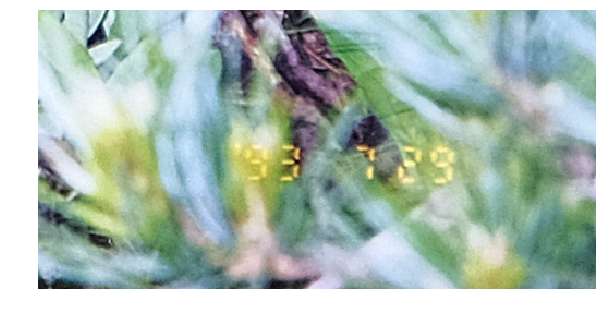

In [0]:
# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


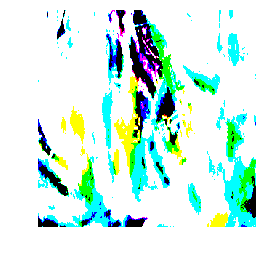

In [0]:
# 画像のサイズを300×300に変更
x = cv2.resize(image, (300, 300)).astype(np.float32)
# 平均のRGBを引く
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
# cv2のチャンネルの順番はBGR（青、緑、赤）なので、RGB（赤、緑、青）に入れ替える
x = x[:, :, ::-1].copy()
plt.axis('off')
plt.imshow(x)
# HWCの形状[300, 300, 3]をCHWの形状[3, 300,300]に変更
x = torch.from_numpy(x).permute(2, 0, 1)

In [0]:
#0次元目にバッチサイズの次元を追加
# [3, 300, 300]　→　[1, 3, 300, 300] 
xx = x.unsqueeze(0)
# GPUへの転送
xx = xx.to(device)
# dropoutを実行しない
net.eval()
# 計算グラフを作成しない
with torch.no_grad():
    # 順伝播を実行し、推論結果を出力
    y = net(xx)

In [0]:
# 1dim:num of data
# 2dim:num of class
# 3dim:confirm ranking
# 4dim:confirm rate and coordinate
y.shape

torch.Size([1, 11, 200, 5])

In [0]:
# 
y[0]

tensor([[[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         

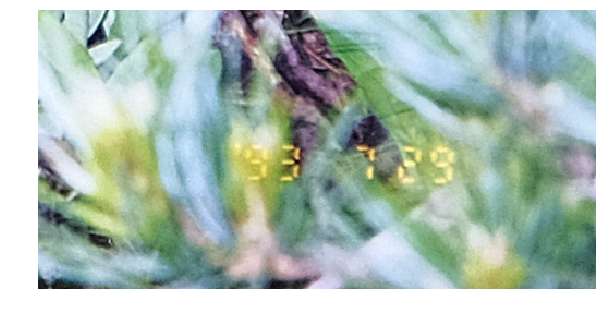

In [0]:
# Display estimation boundingbox
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 11)).tolist()
plt.axis('off')
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# 推論結果をdetectionsに格納
detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
# クラスiでループ
for i in range(detections.size(1)):
    j = 0
# 確信度confが0.6以上のボックスを表示
# if confirm rate more than 0.6, indicate bounding box
# jは確信度上位200件のボックスのインデックス
# detections[0,i,j]は[conf,xmin,ymin,xmax,ymax]の形状
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1

In [0]:
# make dataset for debug
# not transform
test_dataset = VOCDetection(root='input', image_sets='train', transform=None,
                              target_transform=VOCAnnotationTransform())

In [0]:
anno = test_dataset[0][1]
anno = np.array(anno)
box = anno[:,:-1]
label = anno[:,-1]
box = torch.from_numpy(box)
box = box.to(device)
box = box.float()
print(label)

[9. 3. 7. 2. 9.]


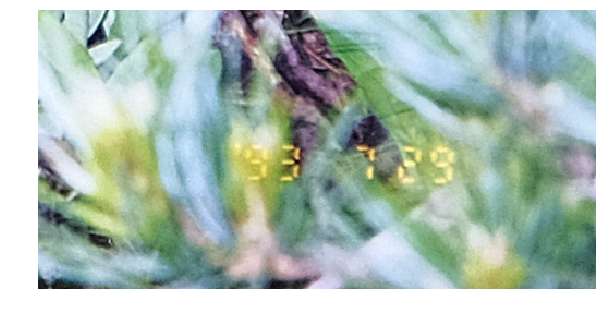

In [0]:
test_image = test_dataset.pull_image(0)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(test_image)
plt.axis('off')
plt.show()

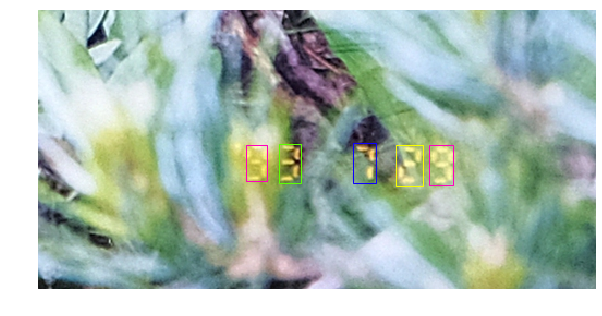

In [0]:
# indicate image and target bounding boxs
plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 10)).tolist()
plt.axis('off')
plt.imshow(test_image)  # plot the image for matplotlib
currentAxis = plt.gca()
# scale each detection back up to the image
scale = torch.Tensor(test_image.shape[1::-1]).repeat(2)
for i, j in zip(box, label):
    pt = i*scale
    pt = pt.cpu()
    pt = pt.numpy()
    coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
    color = colors[0]
    xmin = pt[0]
    ymin = pt[1]
    xmax = pt[2]
    ymax = pt[3]

    plt.gca().add_patch(
        patches.Rectangle(
            xy=(xmin, ymin), width=(xmax - xmin), height=(ymax - ymin),
            fill=False,
            edgecolor=color_map_list[character_list.index(str(int(j)))]
        ))
